# Large scale text analysis with deep learning
# Practice (2 points)

In this assignment, you will develop a deep learning model that predicts salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/) and [Yandex Data School](https://github.com/yandexdataschool/nlp_course/tree/2024/week02_classification)). We will begin this project during our class, but it will require additional effort from you to finalize and submit it as the homework.

To secure full grade for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. You are asked to implement at least two different architectures that reach this MSE.

In [75]:
#!pip install matplotlib

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

### Data from Adzuna challenge
For starters, let's download the data from
1)  [google drive](https://drive.google.com/file/d/1c41JVi3so_GSQ0tPCIsmXsq_dUTSb5iZ/view?usp=sharing), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

Source: Adzuna, Andrew Hunter, Ben Hamner, Fabio, and XiaoJenna. Job Salary Prediction. https://kaggle.com/competitions/job-salary-prediction, 2013. Kaggle.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [77]:
# import gdown
# gdown.download(f"https://drive.google.com/uc?id=1c41JVi3so_GSQ0tPCIsmXsq_dUTSb5iZ", "Train_rev1.zip", quiet=False)

In [78]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [79]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One challenge with salary prediction is its uneven distribution: while many individuals earn standard salaries, a few receive exceptionally high incomes. This results in a right-skewed, heavy-tailed distribution, which poses challenges for minimizing Mean Squared Error (MSE).

Several techniques can address this issue, such as using a different loss function, predicting the logarithm of the target instead of the raw target, or replacing the targets with their percentiles within the salary distribution of the training set. For now, we will use the logarithmic transformation.

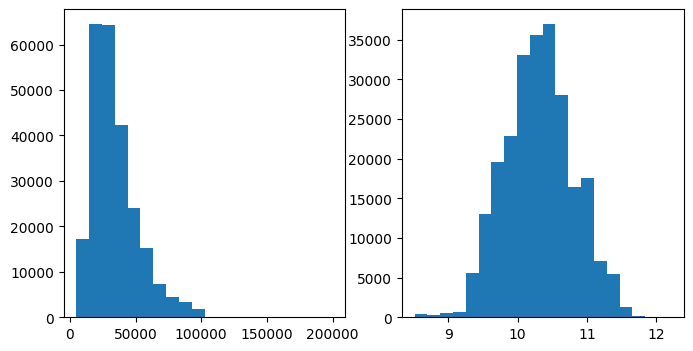

In [80]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [81]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
131498,70192076,Smarter Choices Coordinator,Job Purpose: To encourage more people to take ...,Coventry,Coventry,full_time,NaN,European Solution Limited,Other/General Jobs,32.16 per hour,61747,Jobcentre Plus,11.030817
157952,71125531,Supply Chain Planner,Supply Chain Planner Farnborough Up to **** p...,"Farnborough, Hampshire",Farnborough,NaN,permanent,Orion Electrotech,Engineering Jobs,"0 - 50000/annum pension, bonus",25000,cv-library.co.uk,10.126671
233272,72480707,Senior Support Engineer/ 3rd Line Support Engi...,My client is a market leading Security organis...,Shipley,Shipley,NaN,permanent,TEKsystems,IT Jobs,"22k - 30k pa + bonus, overtime, on call",26000,jobsite.co.uk,10.165891


### Preprocessing text data

We begins with tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for future processing.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [82]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [83]:
import nltk
#TODO
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

data["FullDescription"] = data["FullDescription"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data["Title"] = data["Title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))


Now we can assume that our text is a space-separated list of tokens:

In [84]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some may be typos or rare words that appear only a few times.

To address this, we will count the occurrences of each word in the data to create a "whitelist" of known words.

In [ ]:
data['Title'].values[0]

'Engineering Jobs'

In [86]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for text in data["Title"].values:
    token_counts.update(text.split())
for text in data["FullDescription"].values:
    token_counts.update(text.split())



In [87]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


The word distribution fallows so called [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

In [88]:
token_counts.most_common(100)

[('and', 2657388),
 ('.', 2523216),
 (',', 2318606),
 ('the', 2080994),
 ('to', 2019884),
 ('a', 1521925),
 ('of', 1426213),
 ('in', 1035792),
 ('for', 867233),
 ('with', 728884),
 ('you', 694177),
 ('****', 681869),
 ('will', 652403),
 ('be', 625163),
 ('is', 599665),
 ('/', 554003),
 ('this', 497002),
 ('as', 472859),
 ('an', 442713),
 ('experience', 429019),
 ('are', 428534),
 (':', 415648),
 ('on', 394777),
 ('have', 361514),
 ('or', 329512),
 ('role', 292680),
 ('work', 280280),
 ('business', 275975),
 ('your', 275371),
 ('team', 271843),
 ('we', 238825),
 ('skills', 236248),
 ('manager', 235225),
 ('(', 234419),
 ('sales', 229086),
 ('our', 223441),
 ('working', 222783),
 ('within', 217418),
 ('all', 216046),
 ('that', 200655),
 ('client', 198691),
 ('management', 190344),
 (')', 185958),
 ('their', 185011),
 ('company', 177583),
 ('at', 171875),
 ('please', 171870),
 ('development', 168938),
 ('uk', 163958),
 ('from', 162263),
 ('support', 161650),
 ('job', 156315),
 ('looking',

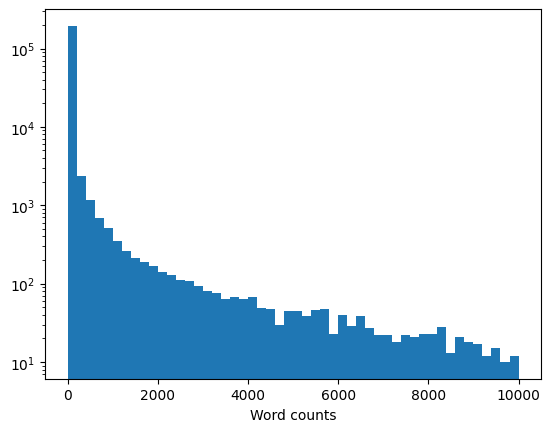

In [89]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [90]:
# len([token for token, count in token_counts.items() if count > 100])

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [91]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [92]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build the inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [93]:
token_to_id =  {token: idx for idx, token in enumerate(tokens)}

In [94]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [95]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [96]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now, let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings.

In [97]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to cast our data into numbers, we can design a machine learning experiment.

We won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and building the vocabulary. A more strict way would be to do that on training set only.

In [98]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a torch-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1)) #.sum(axis=1) #.argmax(axis=1)
    batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    if word_dropout != 0:
        batch["Title"] = apply_word_dropout(batch["Title"], 1. - word_dropout)

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [100]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[   18,   287,   359,     1,     1,     1,     1],
         [ 2863,    11,    12,    13,    55,    37, 12109],
         [ 2833,   618,   858,    63,  7104,  7105,    64]], device='cuda:0'),
 'FullDescription': tensor([[   18,   287,   359,  1408,   561,    18,   287,   359,  1464,  1408],
         [ 2863,    11,    12,    13,    55,    37, 12109,  1767,  1166,    74],
         [  142,  1617,  8830,  1314,  1464,   559,   560,   561,   618,   858]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [101]:
class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embed_size=64):
        """ a simple sequential encoder for titles """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embed_size)
        self.conv = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
    
    def forward(self, X):
        """
        :param X: int64 (n_samples, n_tokens) matrix of token indices
        :returns: float32 (n_samples, out_size) matrix of sentence vectors
        """
        h = self.emb(X).transpose(1, 2)
        h = self.relu(self.conv(h))
        return self.pool(h).squeeze()
        

In [102]:
enc = TextEncoder()
enc.to(device)
enc(make_batch(data_train[:3], max_len=10)["Title"]).shape

torch.Size([3, 64])

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=100):
        super().__init__()
    
        self.title_encoder = TextEncoder(n_tokens, out_size=hid_size, embed_size=hid_size) # during the lecture practice, Prof only used the title_encoder, but the graph said to also have a description encoder 
        self.description_encoder = TextEncoder(n_tokens, out_size=hid_size, embed_size=hid_size)
        self.cat_encoder = nn.Linear(n_cat_features, hid_size) # added the categorical encoder to the model which was not added in the lecture
        self.fc = nn.Linear(hid_size, 1)


    def forward(self, batch):
        return self.fc(self.title_encoder(batch["Title"])).squeeze()+self.fc(self.description_encoder(batch["FullDescription"]).squeeze()+self.fc(self.cat_encoder(batch["Categorical"]).squeeze())).squeeze()


In [193]:
model = SalaryPredictor()

In [194]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [106]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [107]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [108]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [195]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


12239it [02:40, 76.44it/s]                            


 results:
Mean square error: 0.12522
Mean absolute error: 0.26928
epoch: 1


12239it [02:27, 83.24it/s]                            


 results:
Mean square error: 0.11249
Mean absolute error: 0.25808
epoch: 2


12239it [02:21, 86.58it/s]                            


 results:
Mean square error: 0.09960
Mean absolute error: 0.23848
epoch: 3


12239it [02:19, 87.72it/s]                           


 results:
Mean square error: 0.09276
Mean absolute error: 0.23115
epoch: 4


12239it [02:30, 81.16it/s]                           


 results:
Mean square error: 0.09815
Mean absolute error: 0.24134
epoch: 5


12239it [02:25, 84.12it/s]                            


 results:
Mean square error: 0.09723
Mean absolute error: 0.23677
epoch: 6


  2%|▏         | 199/12238 [00:03<03:06, 64.57it/s]


KeyboardInterrupt: 

# Homework (8 points)

Your main task is to use some of the tricks you've learned about NN and analyze if you can improve __validation MAE__. Try __at least 2 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)},$$
where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping.
* Maintain the best-on-validation snapshot via `model.save(file_name)`
* Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

## Option A:

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embed_size=128): # Greater embed size than original
        super().__init__()
        
        self.emb = nn.Embedding(n_tokens, embed_size)
        
        # Triple the number of convolutions and add batch normalization to CNN architecture
        self.conv1 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(out_size)

        self.conv2 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(out_size)

        self.conv3 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(out_size)

        self.dropout = nn.Dropout(0.3) # Add dropout to CNN architecture
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, X):
        h = self.emb(X).transpose(1, 2)
        
        h1 = self.relu(self.bn1(self.conv1(h)))
        h2 = self.relu(self.bn2(self.conv2(h)))
        h3 = self.relu(self.bn3(self.conv3(h)))

        return self.pool(self.dropout(h1 + h2 + h3)).squeeze()


class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=100):
        super().__init__()
        self.title_encoder = ConvEncoder(n_tokens, out_size=hid_size, embed_size=hid_size) # during the lecture practice, Prof only used the title_encoder, but the graph said to also have a description encoder 
        self.description_encoder = ConvEncoder(n_tokens, out_size=hid_size, embed_size=hid_size)
        self.fc = nn.Linear(hid_size, 1)
        

    def forward(self, batch):
        return self.fc(self.title_encoder(batch["Title"])).squeeze()+self.fc(self.description_encoder(batch["FullDescription"]).squeeze()).squeeze()
  

In [111]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [112]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: nan
Mean absolute error: nan
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: nan
Mean absolute error: nan
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: nan
Mean absolute error: nan
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: nan
Mean absolute error: nan
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: nan
Mean absolute error: nan


## Option B

In [113]:
class AttnEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embed_size=128): # Greater embed size than original
        super().__init__()
        
        # Implement initial single-convolution layer of CNN architecture
        self.emb = nn.Embedding(n_tokens, embed_size)
        self.conv = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.relu = nn.ReLU()

        # Add attention layer to CNN architecture
        self.attn = nn.Linear(out_size, 1)

    def forward(self, X):
        h = self.emb(X).transpose(1, 2)
        h = self.relu(self.conv(h))

        # Compute attention weights and apply them to the output of the convolutional layer
        attn_scores = self.attn(h.transpose(1, 2)).squeeze(2)
        attn_weights = F.softmax(attn_scores, dim=1)

        return torch.bmm(attn_weights.unsqueeze(1), h.transpose(1, 2)).squeeze(1)

    


class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=100):
        super().__init__()
        self.title_encoder = AttnEncoder(n_tokens, out_size=hid_size, embed_size=hid_size) # during the lecture practice, Prof only used the title_encoder, but the graph said to also have a description encoder 
        self.description_encoder = AttnEncoder(n_tokens, out_size=hid_size, embed_size=hid_size)
        self.fc = nn.Linear(hid_size, 1)
        

    def forward(self, batch):
        return self.fc(self.title_encoder(batch["Title"])).squeeze()+self.fc(self.description_encoder(batch["FullDescription"]).squeeze()).squeeze()
  

In [114]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [115]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.17193
Mean absolute error: 0.32698
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.13685
Mean absolute error: 0.28510
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11833
Mean absolute error: 0.25951
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10936
Mean absolute error: 0.25001
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10580
Mean absolute error: 0.24436


## Option E

In [116]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=100):
        super().__init__()
    
        self.title_encoder = TextEncoder(n_tokens, out_size=hid_size, embed_size=hid_size) # during the lecture practice, Prof only used the title_encoder, but the graph said to also have a description encoder 
        self.description_encoder = TextEncoder(n_tokens, out_size=hid_size, embed_size=hid_size)
        self.fc = nn.Linear(hid_size, 1)
        

    def forward(self, batch):
        return self.fc(self.title_encoder(batch["Title"])).squeeze()+self.fc(self.description_encoder(batch["FullDescription"]).squeeze()).squeeze()


In [117]:
import os
import shutil

EPOCHS = 25
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt"))


if os.path.exists("train"):
    it = len(os.listdir("train"))
else:
    it = 0
    os.mkdir("train")

path = f"train/exp{it}" # structure inspired by YOLO experiment structure

os.mkdir(path)

best = None

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), f"{path}/epoch{epoch}.pt")
    mse, mae = print_metrics(model, data_val, device=device)
    if best is None or mse < best:
        best = mse
        torch.save(model.state_dict(), f"{path}/best_model.pt")

if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt"))
    mse, mae = print_metrics(model, data_val, device=device)
    if best > mse:
        shutil.copy(f"{path}/best_model.pt", "best_model.pt")


epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.13781
Mean absolute error: 0.28252
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.15270
Mean absolute error: 0.31154
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 results:
Mean square error: 0.09564
Mean absolute error: 0.23751
epoch: 10


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08325
Mean absolute error: 0.21687
epoch: 11


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08409
Mean absolute error: 0.21708
epoch: 12


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08694
Mean absolute error: 0.22369
epoch: 13


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08979
Mean absolute error: 0.22929
epoch: 14


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08658
Mean absolute error: 0.22376
epoch: 15


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08428
Mean absolute error: 0.21806
epoch: 16


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08634
Mean absolute error: 0.22140
epoch: 17


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07811
Mean absolute error: 0.20854
epoch: 18


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09262
Mean absolute error: 0.23407
epoch: 19


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07716
Mean absolute error: 0.20734
epoch: 20


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07963
Mean absolute error: 0.21113
epoch: 21


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08465
Mean absolute error: 0.22112
epoch: 22


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08111
Mean absolute error: 0.21343
epoch: 23


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07782
Mean absolute error: 0.20821
epoch: 24


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07850
Mean absolute error: 0.20930


## Option A, B, and E together

In [185]:
class ConvAttnEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embed_size=128): # Greater embed size than original
        super().__init__()
        
        self.emb = nn.Embedding(n_tokens, embed_size)
        
        # Triple the number of convolutions and add batch normalization to CNN architecture
        self.conv1 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(out_size)

        self.conv2 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(out_size)

        self.conv3 = nn.Conv1d(embed_size, out_size, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(out_size)

        self.dropout = nn.Dropout(0.3) # Add dropout to CNN architecture
        self.relu = nn.ReLU()
        
        self.attn = nn.Linear(out_size, 1)

    def forward(self, X):
        h = self.emb(X).transpose(1, 2)
        
        h1 = self.relu(self.bn1(self.conv1(h)))
        h2 = self.relu(self.bn2(self.conv2(h)))
        h3 = self.relu(self.bn3(self.conv3(h)))

        h = h1+h2+h3

        attn_scores = self.attn(h.transpose(1, 2)).squeeze(2)
        attn_weights = F.softmax(attn_scores, dim=1)

        return self.dropout(torch.bmm(attn_weights.unsqueeze(1), h.transpose(1, 2)).squeeze(1))


class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=100):
        super().__init__()
        self.title_encoder = ConvAttnEncoder(n_tokens, out_size=hid_size, embed_size=hid_size) # during the lecture practice, Prof only used the title_encoder, but the graph said to also have a description encoder 
        #self.description_encoder = ConvAttnEncoder(n_tokens, out_size=hid_size, embed_size=hid_size)
        self.fc = nn.Linear(hid_size, 1)
        

    def forward(self, batch):
        return self.fc(self.title_encoder(batch["Title"])).squeeze()
  

In [186]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [ ]:
import os
import shutil

EPOCHS = 25
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt"))


if os.path.exists("train"):
    it = len(os.listdir("train"))
else:
    it = 0
    os.mkdir("train")

path = f"train/exp{it}" # structure inspired by YOLO experiment structure

os.mkdir(path)

best = None

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), f"{path}/epoch{epoch}.pt")
    mse, mae = print_metrics(model, data_val, device=device)
    if best is None or mse < best:
        best = mse
        torch.save(model.state_dict(), f"{path}/best_model.pt")

if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt"))
    mse, mae = print_metrics(model, data_val, device=device)
    if best > mse:
        shutil.copy(f"{path}/best_model.pt", "./best_model.pt")


epoch: 0


12239it [02:42, 75.44it/s]                           


 results:
Mean square error: 0.27798
Mean absolute error: 0.42962
epoch: 1


12239it [02:30, 81.12it/s]                           


 results:
Mean square error: 0.16394
Mean absolute error: 0.31044
epoch: 2


12239it [02:30, 81.43it/s]                           


 results:
Mean square error: 0.16088
Mean absolute error: 0.31653
epoch: 3


12239it [02:40, 76.48it/s]                           


 results:
Mean square error: 0.12699
Mean absolute error: 0.26833
epoch: 4


12239it [02:28, 82.52it/s]                           


 results:
Mean square error: 0.12447
Mean absolute error: 0.26648
epoch: 5


12239it [02:21, 86.29it/s]                           


 results:
Mean square error: 0.12249
Mean absolute error: 0.26595
epoch: 6


 24%|██▎       | 2877/12238 [00:33<01:50, 84.93it/s]


KeyboardInterrupt: 

### A short report

Please tell us what you did and how did it work.

```
For started, I added the rest of the diagram's layers to the Salary Predictor class in the practice section. When using both Title and Description encoding, it was able to generate a loss of ~0.135 within the first epoch as opposed to ~0.278 MSE during epoch 0 when only using the Title (and still only getting 0.122 by epoch 6); adding the Categorical Encoder made it better still at 0.125 during the first epoch and as low as 0.092 by the third epoch, which is already amazing as far as an MSE score goes. 
 


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)